<a href="https://colab.research.google.com/github/Bluedata-Consulting/GAAPB01-training-code-base/blob/main/SELFLEARNING_LangChain_Chains_Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chains - Routing

# How to route between sub-chains

:::info Prerequisites

This guide assumes familiarity with the following concepts:
- [LangChain Expression Language (LCEL)](/docs/concepts/#langchain-expression-language)
- [Chaining runnables](/docs/how_to/sequence/)
- [Configuring chain parameters at runtime](/docs/how_to/configure)
- [Prompt templates](/docs/concepts/#prompt-templates)
- [Chat Messages](/docs/concepts/#message-types)

:::

Routing allows you to create non-deterministic chains where the output of a previous step defines the next step. Routing can help provide structure and consistency around interactions with models by allowing you to define states and use information related to those states as context to model calls.

There are two ways to perform routing:

1. Conditionally return runnables from a [`RunnableLambda`](/docs/how_to/functions) (recommended)
2. Using a `RunnableBranch` (legacy)

We'll illustrate both methods using a two step sequence where the first step classifies an input question as being about `LangChain`, `Anthropic`, or `Other`, then routes to a corresponding prompt chain.

## Example Setup
First, let's create a chain that will identify incoming questions as being about `LangChain`, `Anthropic`, or `Other`:

In [1]:
model_name='gemini-2.0-flash'

In [2]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate


from langchain.chat_models import init_chat_model
model = init_chat_model(model_name, model_provider="google_genai")

chain = (
    PromptTemplate.from_template(
        """Given the user question below, classify it as either being about `LangChain`, `Gemini`, or `Other`.

Do not respond with more than one word.

<question>
{question}
</question>

Classification:"""
    )
    | model
    | StrOutputParser()
)

chain.invoke({"question": "how do I call Gemini?"})

C:\Users\Anshu Pandey\AppData\Local\Temp\ipykernel_18272\3127084504.py:6: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  model = init_chat_model(model_name, model_provider="google_genai")


'Gemini\n'

In [3]:
chain.invoke({"question": "how do I use LangChain?"})

'LangChain\n'

In [4]:
chain.invoke({"question": "what are the models available with OpenAI API?"})

'Other\n'

Now, let's create three sub chains:

In [5]:
langchain_chain = PromptTemplate.from_template(
    """You are an expert in langchain. \
Always answer questions starting with "As Harrison Chase told me". \
Respond to the following question:

Question: {question}
Answer:"""
) | model



gemini_chain = PromptTemplate.from_template(
    """You are an expert in Vertex AI Gemini Models. \
Always answer questions starting with "As Sundar Pichai told me". \
Respond to the following question:

Question: {question}
Answer:"""
) | model


general_chain = PromptTemplate.from_template(
    """Respond to the following question:

Question: {question}
Answer:"""
) | model

## Using a custom function (Recommended)

You can also use a custom function to route between different outputs. Here's an example:

In [6]:
def route(info):
    if "gemini" in info["topic"].lower():
        return gemini_chain
    elif "langchain" in info["topic"].lower():
        return langchain_chain
    else:
        return general_chain

In [7]:
from langchain_core.runnables import RunnableLambda

full_chain = {"topic": chain, "question": lambda x: x["question"]} | RunnableLambda(
    route
)

In [8]:
full_chain.invoke({"question": "how do I use Gemini?"})

AIMessage(content="As Sundar Pichai told me, you can use Gemini through various channels, depending on your needs and technical expertise:\n\n*   **Google AI Studio (Maker Suite):** This is a web-based interface designed for prototyping and experimenting with Gemini. It's perfect for beginners and allows you to quickly test different prompts and parameters without writing any code. You can access it at [https://makersuite.google.com/app/home](https://makersuite.google.com/app/home).\n\n*   **Vertex AI (Developer Suite):** For more advanced users and production deployments, Vertex AI offers a robust platform. It provides the following:\n    *   **API Access:** You can use the Gemini API to integrate the model into your applications. This requires coding in languages like Python, Node.js, Java, etc., using the Google Cloud Client Libraries.\n    *   **Vertex AI Workbench:** A managed Jupyter notebook environment for data exploration, model development, and experimentation.\n    *   **Mod

In [9]:
full_chain.invoke({"question": "how do I use LangChain?"})

AIMessage(content='As Harrison Chase told me, using LangChain is all about leveraging its modular components to build sophisticated language applications. Here\'s a breakdown of how you can approach it:\n\n**1. Understanding the Core Modules:**\n\nLangChain is built around several key modules. You\'ll want to familiarize yourself with these:\n\n*   **Models:** This is where you interface with different language models (LLMs) like OpenAI\'s GPT models, Cohere, Hugging Face models, and more. You can interact with them for text generation, summarization, translation, etc.\n*   **Prompts:** Prompts are the instructions you give to the language model. LangChain helps you manage and optimize prompts using PromptTemplates, Example Selectors, and Output Parsers.  Effective prompting is crucial for getting the desired output.\n*   **Chains:** Chains are sequences of calls to LLMs or other utilities. They link together different components to create more complex applications. Common chains inclu

In [10]:
full_chain.invoke({"question": "whats 2 + 2"})

AIMessage(content='4\n', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d5a97293-4f5a-4971-9190-af9327459840-0', usage_metadata={'input_tokens': 18, 'output_tokens': 2, 'total_tokens': 20})

## Using a RunnableBranch

A `RunnableBranch` is a special type of runnable that allows you to define a set of conditions and runnables to execute based on the input. It does **not** offer anything that you can't achieve in a custom function as described above, so we recommend using a custom function instead.

A `RunnableBranch` is initialized with a list of (condition, runnable) pairs and a default runnable. It selects which branch by passing each condition the input it's invoked with. It selects the first condition to evaluate to True, and runs the corresponding runnable to that condition with the input.

If no provided conditions match, it runs the default runnable.

Here's an example of what it looks like in action:

In [11]:
from langchain_core.runnables import RunnableBranch

branch = RunnableBranch(
    (lambda x: "gemini" in x["topic"].lower(), gemini_chain),
    (lambda x: "langchain" in x["topic"].lower(), langchain_chain),
    general_chain,
)
full_chain = {"topic": chain, "question": lambda x: x["question"]} | branch
full_chain.invoke({"question": "how do I use Gemini?"})

AIMessage(content="As Sundar Pichai told me, you can use Gemini in a few key ways:\n\n*   **Through the Vertex AI API:** This is for developers and businesses who want to integrate Gemini's capabilities directly into their applications, workflows, and products. You'll be able to access the models programmatically and customize them for specific tasks. You'll need a Google Cloud project and familiarity with coding to use this method.\n\n*   **Through the Google AI Studio:** This is a web-based interface designed for prototyping and experimenting with Gemini. It's a great way to get hands-on experience with the model, test different prompts, and explore its capabilities without writing any code. It's more user-friendly for those who aren't developers.\n\n*   **Through Google Products:** Gemini is being integrated into various Google products like Search, Workspace (Gmail, Docs, Sheets, Slides), and more. This means you'll be able to leverage Gemini's AI power directly within the tools yo

In [12]:
full_chain.invoke({"question": "how do I use LangChain?"})

AIMessage(content='As Harrison Chase told me, using LangChain involves a few key steps:\n\n1. **Installation:** First, you\'ll need to install the LangChain Python package. You can do this using pip: `pip install langchain`. You might also need to install other packages depending on the specific integrations you plan to use (e.g., `pip install openai` for OpenAI models).\n\n2. **Choosing a Model:** LangChain is all about working with language models. You\'ll need to select a language model provider (like OpenAI, Cohere, Hugging Face, or even a local model). Then, you\'ll instantiate the model object in LangChain. For example, using OpenAI:\n\n   ```python\n   from langchain.llms import OpenAI\n\n   llm = OpenAI(openai_api_key="YOUR_API_KEY") # Replace with your actual API key\n   ```\n\n3. **Chains:** The core concept in LangChain is the "Chain". Chains are sequences of calls to language models or other utilities. The simplest chain just passes your input directly to the language model

In [13]:
full_chain.invoke({"question": "whats 2 + 2"})

AIMessage(content='4\n', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-13925d1c-f4f2-4f1c-9482-c2a16e7894f7-0', usage_metadata={'input_tokens': 18, 'output_tokens': 2, 'total_tokens': 20})

# Using Langgraph

In [16]:
from typing_extensions import TypedDict

# Define the state using Pydantic
class QuestionState(TypedDict):
    question: str
    topic: str
    answer: str


In [19]:

from langgraph.graph import StateGraph

def classify_topic(state: QuestionState) -> QuestionState:
    topic = chain.invoke({"question": state['question']})
    state.topic = topic
    return {"topic":topic}

In [20]:
def route_graph(state: QuestionState) -> str:
    topic = (state.topic or "").lower()
    if "gemini" in topic:
        return "gemini"
    elif "langchain" in topic:
        return "langchain"
    else:
        return "general"

def run_langchain(state: QuestionState) -> QuestionState:
    answer = langchain_chain.invoke({"question": state.question})
    return {"answer":answer}

def run_gemini(state: QuestionState) -> QuestionState:
    answer = gemini_chain.invoke({"question": state.question})
    return {"answer":answer}

def run_general(state: QuestionState) -> QuestionState:
    answer = general_chain.invoke({"question": state.question})
    return {"answer":answer}


In [26]:
from langgraph.graph import START, StateGraph, END

graph = StateGraph(QuestionState)
graph.add_node("classify", classify_topic)
graph.add_node("langchain", run_langchain)
graph.add_node("gemini", run_gemini)
graph.add_node("general", run_general)

graph.add_conditional_edges("classify", route_graph,{"gemini":"gemini","general":"general","langchain":'langchain'})
graph.add_edge(START,"classify")
graph.add_edge("general",END)
graph.add_edge("langchain",END)
graph.add_edge("gemini",END)

chain = graph.compile()


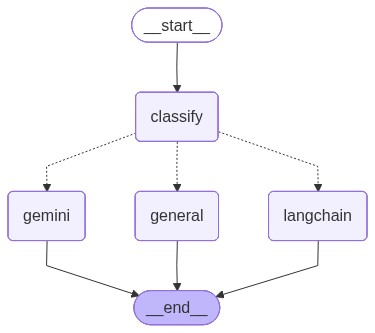

In [27]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
for step in chain.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

## Next steps

You've now learned how to add routing to your composed LCEL chains.

Next, check out the other how-to guides on runnables in this section.